In [1]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, TensorDataset
import abstract_gradient_training as agt
from abstract_gradient_training import model_utils
from abstract_gradient_training import test_metrics
from sklearn.decomposition import PCA
import numpy as np
import os
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

In [2]:
num_components = 32  # Number of principal components to keep

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_train = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_imgs = mnist_train.data
print(train_imgs.shape)
train_imgs = train_imgs.view(train_imgs.shape[0], -1).numpy() / 255.0
test_imgs = mnist_test.data
test_imgs = test_imgs.view(test_imgs.shape[0], -1).numpy() / 255.0

pca = PCA(n_components=num_components)
pca.fit_transform(train_imgs)
pc_train = pca.transform(train_imgs)
pc_test = pca.transform(test_imgs)

torch.Size([60000, 28, 28])


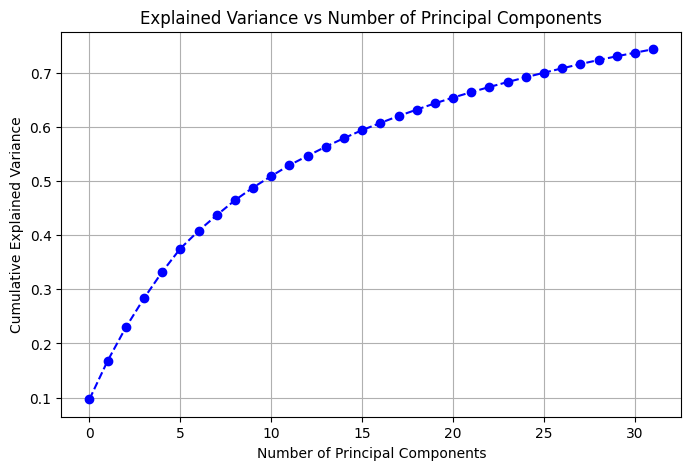

In [3]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
plt.figure(figsize=(8, 5))
plt.plot(cumulative_explained_variance, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of Principal Components')
plt.grid(True)
plt.show()

In [7]:
# configure the training parameters
batchsize = 60000
train_dataset = TensorDataset(torch.tensor(pc_train, dtype=torch.float32), torch.tensor(mnist_train.targets, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(pc_test, dtype=torch.float32), torch.tensor(mnist_test.targets, dtype=torch.long))

idx = np.random.permutation(len(train_dataset))
train_dataset = TensorDataset(train_dataset.tensors[0][idx].double(), train_dataset.tensors[1][idx])
idx = np.random.permutation(len(test_dataset))
test_dataset = TensorDataset(test_dataset.tensors[0][idx].double(), test_dataset.tensors[1][idx])

dl_train = DataLoader(train_dataset, batch_size=batchsize, shuffle=False)
dl_test = DataLoader(test_dataset, batch_size=1000, shuffle=False)

nominal_config = agt.AGTConfig(
    fragsize=5000,
    learning_rate=5.0,
    lr_decay=1.0,
    lr_min=0.001,
    # label_k_poison=1,
    n_epochs=2,
    device="cuda:1",
    forward_bound="interval",
    backward_bound="interval",
    # clip_gamma=0.1,
    # poison_target=1,
    loss="cross_entropy",
    early_stopping=False,
    log_level="DEBUG",
    bound_kwargs={"interval_matmul": "exact"}
)
torch.manual_seed(0)
model = nn.Sequential(
    nn.Linear(num_components, 10),
).to(nominal_config.device).double()

conf = copy.deepcopy(nominal_config)
conf.n_epochs = 10

# train the model
param_l, param_n, param_u = agt.poison_certified_training(model, conf, dl_train, dl_test)

/tmp/ipykernel_2435506/3565874826.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(pc_train, dtype=torch.float32), torch.tensor(mnist_train.targets, dtype=torch.long))
/tmp/ipykernel_2435506/3565874826.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = TensorDataset(torch.tensor(pc_test, dtype=torch.float32), torch.tensor(mnist_test.targets, dtype=torch.long))
[AGT] [INFO    ] [19:24:24] =================== Starting Poison Certified Training ===================
[AGT] [DEBUG   ] [19:24:24] 	Optimizer params: n_epochs=10, learning_rate=5.0, l1_reg=0.0, l2_reg=0.0
[AGT] [DEBUG   ] [19:24:24] 	Learning rate schedule: lr_decay=1.0,

In [8]:
results_dir = ".results/"
seed = 5
notebook_id = f"mnist_poison_{seed}"

def run_with_config(config):
    """If results for this configuration are already computed, load them from disk. Otherwise, run the certified
    training using AGT, then save and return the results."""
    fname = f"{results_dir}/{notebook_id}_{config.hash()}"
    if os.path.isfile(fname):  # run exists, so return the previous results
        param_l, param_n, param_u = torch.load(fname)
    else:
        # check whether the given config should be either unlearning or privacy training
        assert not (config.k_unlearn and config.k_private)
        torch.manual_seed(seed)
        param_l, param_n, param_u = agt.poison_certified_training(
            model, config, dl_train, dl_test, transform=model_utils.propagate_conv_layers
        )
        torch.save((param_l, param_n, param_u), fname)
    # get nominal accuracy (on the Drusen class) and percent certified (on the entire test set)
    accuracy = test_metrics.test_accuracy(
        param_l, param_n, param_u, *next(iter(dl_test)), model, model_utils.propagate_conv_layers
    )
    del param_l, param_n, param_u
    torch.cuda.empty_cache()
    return accuracy

In [9]:
# experiment 1
k_poisons = list(range(0, 101, 5))
clip_gammas = [np.inf, 0.2, 0.1]

results = {}

config = copy.deepcopy(nominal_config)

for gamma in clip_gammas:
    tmp_results = {}
    for k_poison in k_poisons:
        config.label_k_poison = k_poison
        config.clip_gamma = gamma
        tmp_results[k_poison] = run_with_config(config)
    results[gamma] = tmp_results

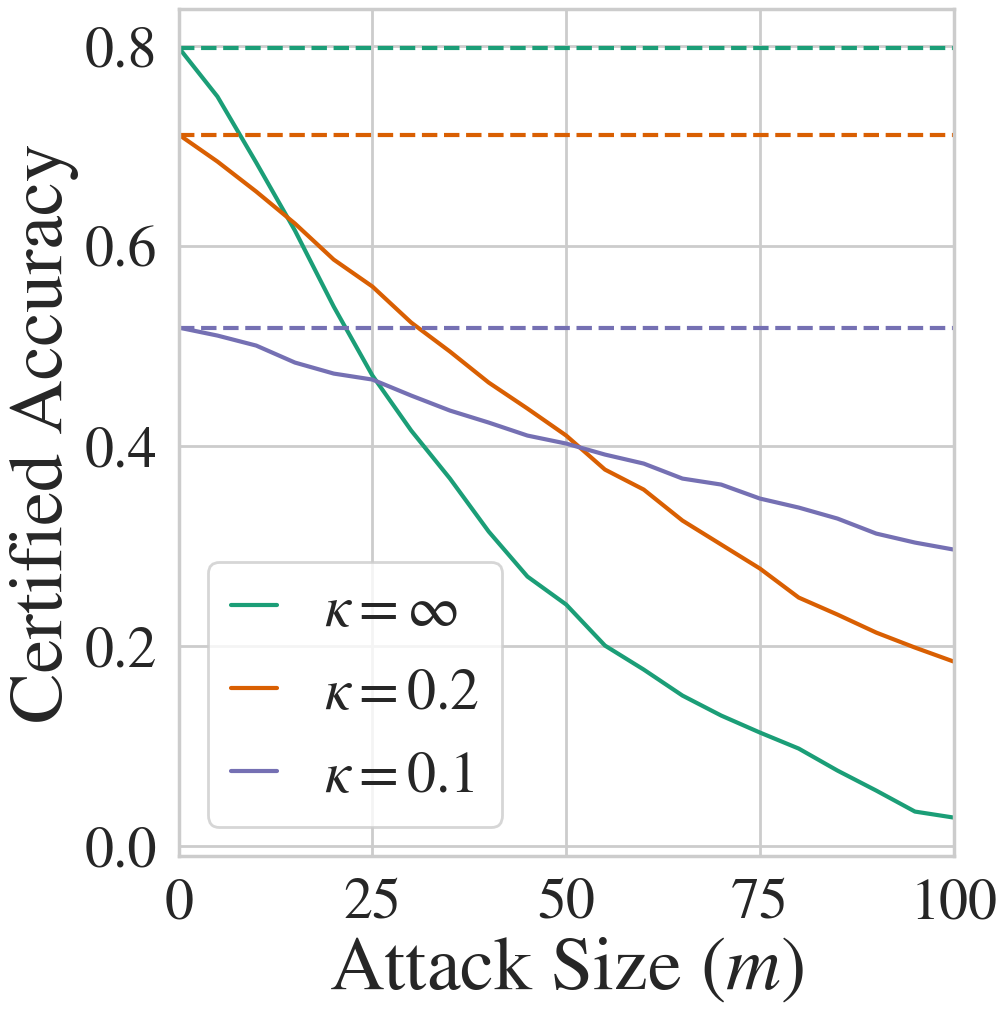

In [11]:
palette = sns.color_palette(palette="Dark2", n_colors=12)
lb_color = list(iter(sns.color_palette(palette="deep")))[-1]
ub_color = list(iter(sns.color_palette(palette="deep")))[-2]

sns.set_theme(context="poster", style="whitegrid", font_scale=1.9)
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.family"] = "STIXGeneral"
labelsize = 22

fig, ax = plt.subplots(
    1,
    1,
    figsize=(10, 11),
)

colors = iter(palette)
for gamma, r in results.items():
    nom_accs = [res[1] for res in r.values()]
    cert_accs = [res[0] for res in r.values()]
    k_poisons = list(r.keys())
    color = next(colors)
    ax.plot(k_poisons, nom_accs, linestyle="--", color=color)
    ax.plot(k_poisons, cert_accs, label=fr"$\kappa={gamma if gamma != np.inf else '∞'}$", color=color)
    
plt.ylabel("Certified Accuracy", fontsize="large")
plt.xlabel("Attack Size ($m$)", fontsize="large")
plt.legend(handlelength=0.8)
plt.xlim(0, max(k_poisons))

plt.savefig(f".figures/mnist_poisoning.pdf", bbox_inches="tight", dpi=300)